# Image Captioning - Data Exploration

This notebook explores the Flickr8k dataset for the image captioning task. We will:

1. Download and prepare the dataset
2. Explore the images and captions
3. Analyze the distribution of caption lengths
4. Examine the vocabulary
5. Visualize some sample images with their captions

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### data/download_flickr.py :


### Importing Modules

In [19]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import nltk
from collections import Counter
from tqdm import tqdm
import re
import string
import seaborn as sns
import random
import textwrap
from nltk.corpus import stopwords

# Add project root to path
project_root = '/content/drive/MyDrive/image-captioning-main'
data_dir = os.path.join(project_root,'data')
os.makedirs(data_dir ,exist_ok = True)
sys.path.append(project_root)

# from utils.vocabulary import Vocabulary, build_vocab_from_captions
from data.download_flickr import download_flickr8k
from utils.vocabulary import Vocabulary, build_vocab_from_captions

## 1. Download and Prepare the Dataset

In [20]:
# Download and prepare the Flickr8k dataset
paths = download_flickr8k(data_dir)

Extracting Flickr8k_text.zip: 100%|██████████| 10/10 [00:00<00:00, 47.06it/s]


Processed captions saved to /content/drive/MyDrive/image-captioning-main/data/flickr8k/processed/captions.csv
Found 8091 images in /content/drive/MyDrive/image-captioning-main/data/flickr8k/processed/images
Created data splits: train (30000 captions), val (5000 captions), test (5000 captions)


In [21]:
# Load the captions
captions_path = os.path.join(paths['processed_path'], 'captions.csv')
captions_df = pd.read_csv(captions_path)

# Display the first few rows
captions_df.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


## 2. Explore the Images and Captions

In [8]:
# Count unique images and total captions
unique_images = captions_df['image'].nunique()
total_captions = len(captions_df)

print(f"Total number of images: {unique_images}")
print(f"Total number of captions: {total_captions}")
print(f"Average captions per image: {total_captions / unique_images:.2f}")

Total number of images: 8092
Total number of captions: 40460
Average captions per image: 5.00


In [22]:
#------------------------------------------------------------------------------------------------
# Display a random sample of images with their captions
# TODO: Implement the function to display images with their captions
# This function should:
# 1. Take a DataFrame of captions, path to images directory, and number of samples ✅
# 2. Get random image samples                                                      ✅
# 3. Create a figure with subplots                                                 ✅
# 4. For each image:                                                               ✅
#    a. Load and display the image
#    b. Find all captions for that image
#    c. Add captions as a formatted title
#------------------------------------------------------------------------------------------------

def display_images_with_captions(captions_df, images_dir, num_samples=5):
    # Get unique images to sample from
    unique_images = captions_df['image'].unique()
    sampled_images = random.sample(list(unique_images), min(num_samples, len(unique_images)))

    # Set up a vertical grid: one image + caption per row
    fig, axes = plt.subplots(num_samples, 1, figsize=(10, num_samples * 4))
    if num_samples == 1:
        axes = [axes]  # Ensure it's iterable

    for ax, image_name in zip(axes, sampled_images):
        image_path = os.path.join(images_dir, image_name)

        if not os.path.exists(image_path):
            print(f"Image not found: {image_path}")
            continue

        # Load image
        img = Image.open(image_path)

        # Display image
        ax.imshow(img)
        ax.axis('off')

        # Get all captions for the image
        all_captions = captions_df[captions_df['image'] == image_name]['caption'].tolist()

        # Wrap and format captions for display
        wrapped_captions = [textwrap.fill(f"{i+1}. {caption}", width=90) for i, caption in enumerate(all_captions)]
        caption_text = "\n".join(wrapped_captions)

        # Display captions below the image
        ax.set_title(caption_text, fontsize=10, loc='left')

    plt.tight_layout()
    plt.show()

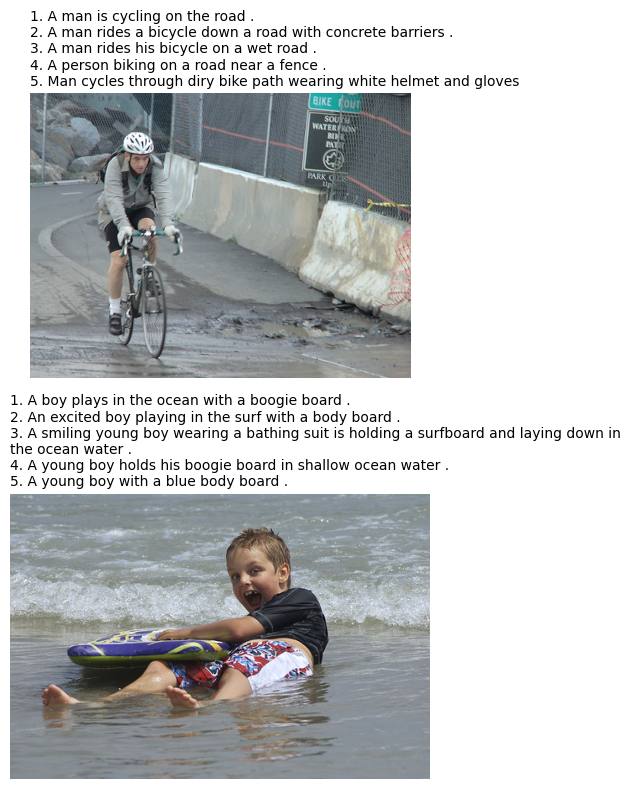

In [14]:
captions_df = pd.read_csv(paths['captions_path'])
images_dir = os.path.join(paths['processed_path'], 'images')
display_images_with_captions(captions_df, images_dir, num_samples=2)

## 3. Analyze Caption Lengths

In [15]:
!pip install nltk
nltk.download('punkt_tab')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


- Tokenizer flow check

In [23]:
def simple_tokenize(caption):
    caption = str(caption).lower().strip()
    caption = re.sub(r'[^\w\s]', '', caption)
    return caption.split()

df = pd.read_csv("./data/flickr8k/processed/captions.csv")
df['tokens'] = df['caption'].apply(simple_tokenize)


token_lengths = df['tokens'].apply(len)
print("Token length stats:")
print(token_lengths.describe())
print("\nSample tokenizations:")
print(df[['caption', 'tokens']].head())

Token length stats:
count    40460.000000
mean        10.789471
std          3.757210
min          1.000000
25%          8.000000
50%         10.000000
75%         13.000000
max         36.000000
Name: tokens, dtype: float64

Sample tokenizations:
                                             caption  \
0  A child in a pink dress is climbing up a set o...   
1              A girl going into a wooden building .   
2   A little girl climbing into a wooden playhouse .   
3  A little girl climbing the stairs to her playh...   
4  A little girl in a pink dress going into a woo...   

                                              tokens  
0  [a, child, in, a, pink, dress, is, climbing, u...  
1        [a, girl, going, into, a, wooden, building]  
2  [a, little, girl, climbing, into, a, wooden, p...  
3  [a, little, girl, climbing, the, stairs, to, h...  
4  [a, little, girl, in, a, pink, dress, going, i...  


In [ ]:
# Tokenize captions
# TODO: Implement the tokenize function for caption text
# This function should:
# 1. Convert text to lowercase                           ✅
# 2. Remove punctuation using regex                      ✅
# 3. Split text into tokens using NLTK's word_tokenize   ✅
# 4. Return the list of tokens                           ✅
#------------------------------------------------------------------------------------------------
def tokenize(text):
    # Your implementation here
    test = str(text).lower().strip()
    text = re.sub(r'[^\w\s]', '', text)
    return text.split()

# Calculate caption lengths
captions_df['tokens'] = captions_df['caption'].apply(tokenize)
captions_df['length'] = captions_df['tokens'].apply(len)

# Display statistics
caption_lengths = captions_df['length']
print(f"Min length: {caption_lengths.min()}")
print(f"Max length: {caption_lengths.max()}")
print(f"Mean length: {caption_lengths.mean():.2f}")
print(f"Median length: {caption_lengths.median()}")
print(f"90th percentile length: {caption_lengths.quantile(0.9)}")
print(f"95th percentile length: {caption_lengths.quantile(0.95)}")

Min length: 1
Max length: 36
Mean length: 10.79
Median length: 10.0
90th percentile length: 16.0
95th percentile length: 18.0


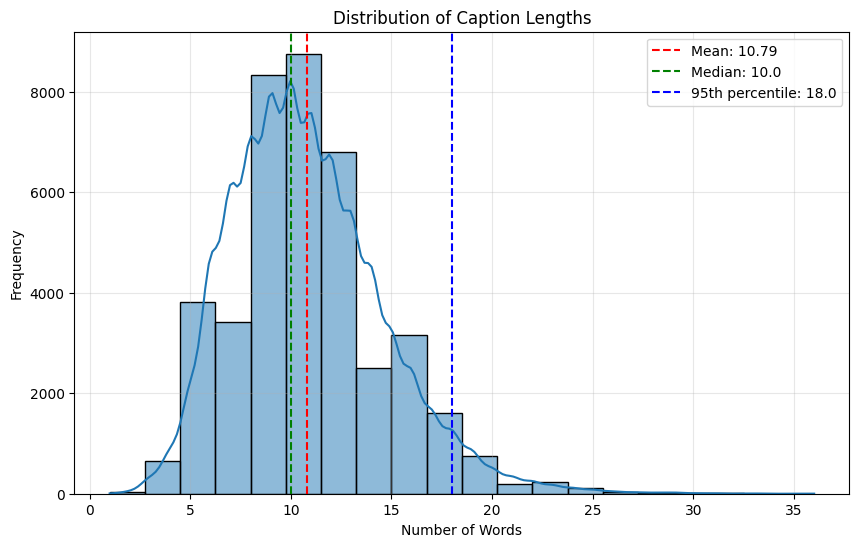

In [ ]:
# Plot the distribution of caption lengths
plt.figure(figsize=(10, 6))
sns.histplot(caption_lengths, bins=20, kde=True)
plt.axvline(x=caption_lengths.mean(), color='r', linestyle='--', label=f'Mean: {caption_lengths.mean():.2f}')
plt.axvline(x=caption_lengths.median(), color='g', linestyle='--', label=f'Median: {caption_lengths.median()}')
plt.axvline(x=caption_lengths.quantile(0.95), color='b', linestyle='--', label=f'95th percentile: {caption_lengths.quantile(0.95)}')
plt.title('Distribution of Caption Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 4. Examine the Vocabulary

In [ ]:
# Count word frequencies
all_tokens = [token for tokens in captions_df['tokens'] for token in tokens]
word_freq = Counter(all_tokens)

# Display statistics
print(f"Total vocabulary size: {len(word_freq)}")
print(f"Number of words appearing only once (Unique): {sum(1 for count in word_freq.values() if count == 1)}")

Total vocabulary size: 9542
Number of words appearing only once (Unique): 4055


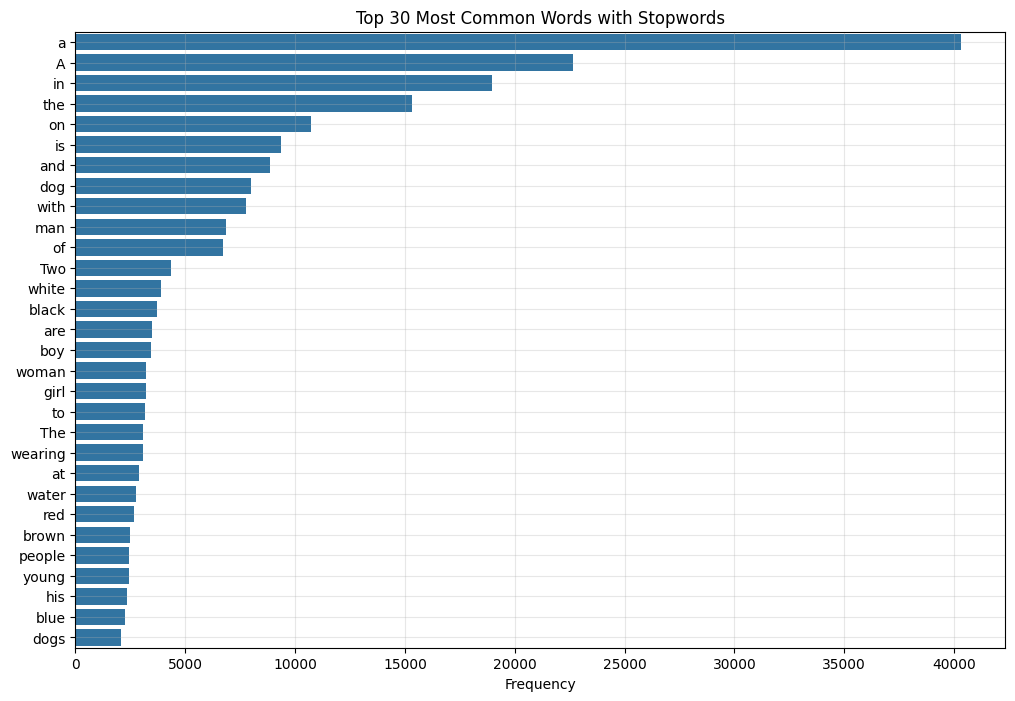

In [ ]:
# Plot the most common words
top_n = 30
most_common = word_freq.most_common(top_n)
words, counts = zip(*most_common)

plt.figure(figsize=(12, 8))
sns.barplot(x=list(counts), y=list(words))
plt.title(f'Top {top_n} Most Common Words with Stopwords')
plt.xlabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

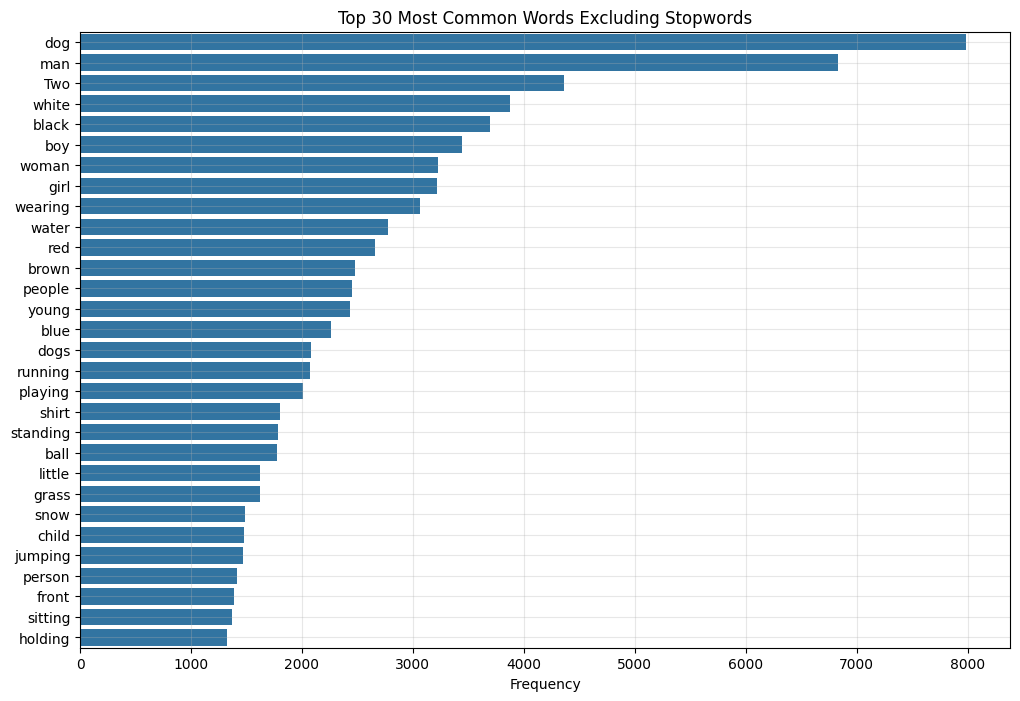

In [ ]:
all_tokens = [
    token for tokens in captions_df['tokens']
    for token in tokens
    if token.lower() not in stop_words
]
word_freq = Counter(all_tokens)

top_n = 30
most_common = word_freq.most_common(top_n)
words, counts = zip(*most_common)

plt.figure(figsize=(12, 8))
sns.barplot(x=list(counts), y=list(words))
plt.title(f'Top {top_n} Most Common Words Excluding Stopwords')
plt.xlabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# Calculate vocabulary coverage with different frequency thresholds
# TODO: Calculate vocabulary coverage for different word frequency thresholds
# For each threshold:
# 1. Find words that appear at least 'threshold' times
# 2. Calculate vocabulary size (number of unique words above threshold)
# 3. Calculate what percentage of all tokens are covered by this vocabulary
# 4. Store results for plotting
thresholds = [1, 2, 3, 5, 7, 10, 100 , 1000]
coverage = []

word_freq = Counter(all_tokens)
total_tokens = sum(word_freq.values())

for threshold in thresholds:
    # Words with frequency >= threshold
    filtered_words = {word: count for word, count in word_freq.items() if count >= threshold}
    vocab_size = len(filtered_words)

    # Calculate coverage: sum of frequencies of included words / total tokens
    covered_tokens = sum(filtered_words.values())
    coverage_pct = (covered_tokens / total_tokens) * 100

    coverage.append((threshold, vocab_size, coverage_pct))
    print(f"Threshold: {threshold}, Vocabulary size: {vocab_size}, Coverage: {coverage_pct:.2f}%")

Threshold: 1, Vocabulary size: 9383, Coverage: 100.00%
Threshold: 2, Vocabulary size: 5357, Coverage: 98.40%
Threshold: 3, Vocabulary size: 4113, Coverage: 97.41%
Threshold: 5, Vocabulary size: 2992, Coverage: 95.89%
Threshold: 7, Vocabulary size: 2400, Coverage: 94.62%
Threshold: 10, Vocabulary size: 1901, Coverage: 93.04%
Threshold: 100, Vocabulary size: 374, Coverage: 74.31%
Threshold: 1000, Vocabulary size: 45, Coverage: 38.38%


- removing rare words (appearing < 5 times) has minimal loss.
Those 3099 still cover 97.62% of all word usage in your dataset



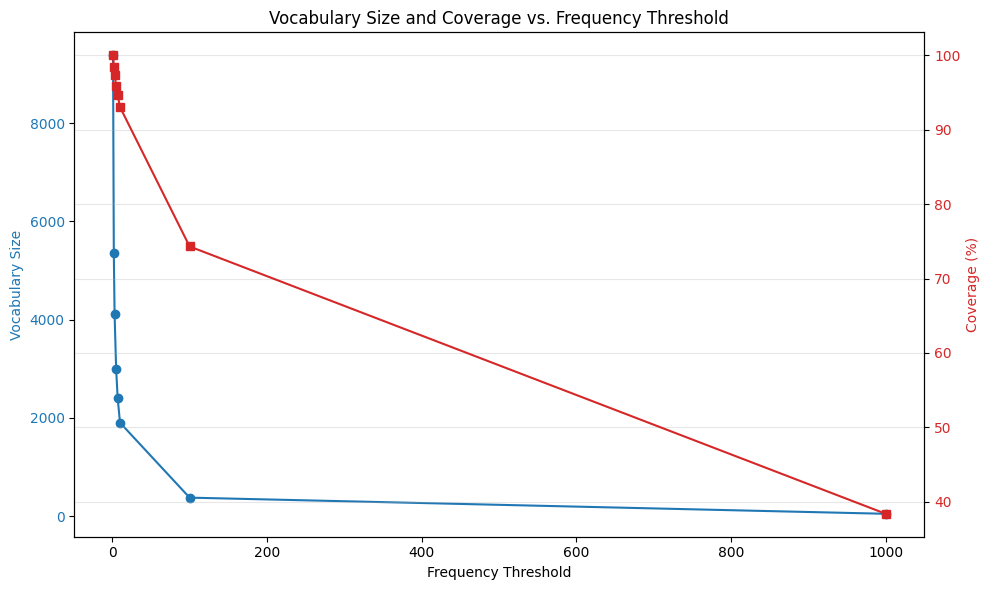

In [ ]:
# Plot vocabulary coverage
thresholds, vocab_sizes, coverages = zip(*coverage)

fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot vocabulary size
color = 'tab:blue'
ax1.set_xlabel('Frequency Threshold')
ax1.set_ylabel('Vocabulary Size', color=color)
ax1.plot(thresholds, vocab_sizes, 'o-', color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create second y-axis for coverage
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Coverage (%)', color=color)
ax2.plot(thresholds, coverages, 's-', color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Vocabulary Size and Coverage vs. Frequency Threshold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

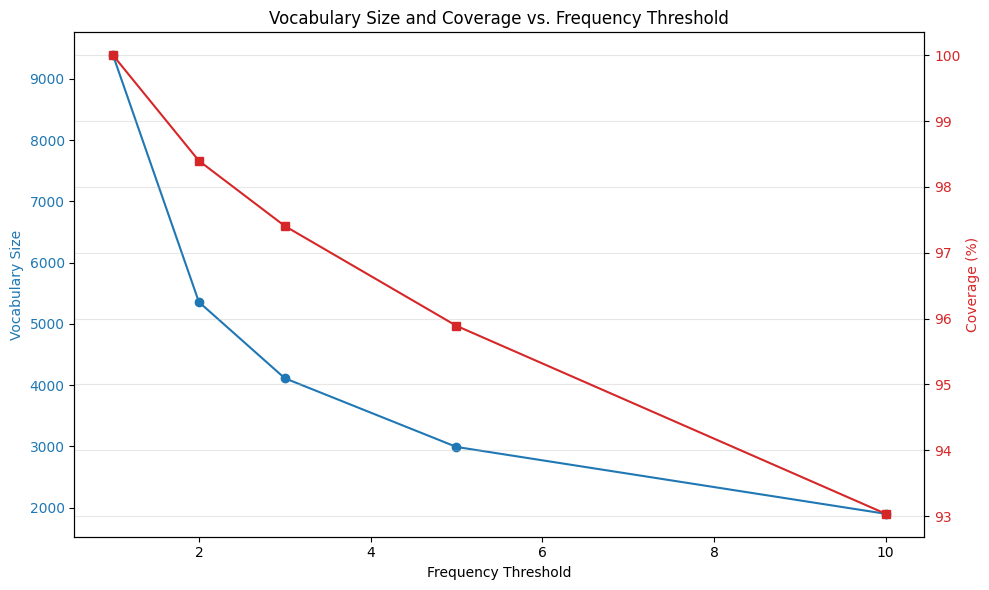

In [ ]:
thresholds = [1, 2, 3, 5, 10]
coverage = []

word_freq = Counter(all_tokens)
total_tokens = sum(word_freq.values())

for threshold in thresholds:
    # Words with frequency >= threshold
    filtered_words = {word: count for word, count in word_freq.items() if count >= threshold}
    vocab_size = len(filtered_words)

    # Calculate coverage: sum of frequencies of included words / total tokens
    covered_tokens = sum(filtered_words.values())
    coverage_pct = (covered_tokens / total_tokens) * 100

    coverage.append((threshold, vocab_size, coverage_pct))

# Plot vocabulary coverage
thresholds, vocab_sizes, coverages = zip(*coverage)

fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot vocabulary size
color = 'tab:blue'
ax1.set_xlabel('Frequency Threshold')
ax1.set_ylabel('Vocabulary Size', color=color)
ax1.plot(thresholds, vocab_sizes, 'o-', color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create second y-axis for coverage
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Coverage (%)', color=color)
ax2.plot(thresholds, coverages, 's-', color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Vocabulary Size and Coverage vs. Frequency Threshold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Build and Save the Vocabulary

In [24]:
# Build and save the vocabulary
freq_threshold = 5  # Words appearing less than 5 times are considered rare
vocab = build_vocab_from_captions(captions_path, paths['processed_path'], freq_threshold=freq_threshold)

print(f"Built vocabulary with {len(vocab)} words")

Vocabulary built with 2986 words
Saved to /content/drive/MyDrive/image-captioning-main/data/flickr8k/processed/vocabulary.pkl
Built vocabulary with 2986 words


## 6. Explore Data Splits

In [ ]:
# Load data splits
train_df = pd.read_csv(os.path.join(paths['processed_path'], 'train_captions.csv'))
val_df = pd.read_csv(os.path.join(paths['processed_path'], 'val_captions.csv'))
test_df = pd.read_csv(os.path.join(paths['processed_path'], 'test_captions.csv'))

# Display statistics
print(f"Training set: {train_df['image'].nunique()} images, {len(train_df)} captions")
print(f"Validation set: {val_df['image'].nunique()} images, {len(val_df)} captions")
print(f"Test set: {test_df['image'].nunique()} images, {len(test_df)} captions")

Training set: 6000 images, 30000 captions
Validation set: 1000 images, 5000 captions
Test set: 1000 images, 5000 captions


## 7. Check Image Dimensions

In [ ]:
def check_image_dimensions(images_dir, num_samples=100):
    """
    Analyze dimensions of a sample of images in the dataset.

    Args:
        images_dir (str): Path to the directory containing images
        num_samples (int): Number of images to sample for analysis

    Returns:
        pd.DataFrame: DataFrame containing width and height of each sampled image
    """

    #-------------------------------------------------------------------------------------------
    # Check image dimensions for a sample of images
    # TODO: Implement a function to analyze image dimensions in the dataset
    # This function should:
    # 1. Get a sample of image files from the directory                 ✅
    # 2. Load each image and extract its dimensions                     ✅
    # 3. Return a DataFrame with width and height columns for analysis  ✅

    # Get list of image files
    image_files = [
        os.path.join(images_dir, fname)
        for fname in os.listdir(images_dir)
        if fname.lower().endswith((".jpg", ".jpeg", ".png"))
    ]

    # 1.
    sampled_files = random.sample(image_files, min(num_samples, len(image_files)))

    # 2.
    dimensions = []
    for file in sampled_files:
        try:
            with Image.open(file) as img:
                width, height = img.size
                dimensions.append((width, height))
        except Exception as e:
            print(f"Error loading image {file}: {e}")

    # 3.
    dim_df = pd.DataFrame(dimensions, columns=["width", "height"])
    return dim_df
    #-------------------------------------------------------------------------------------------

In [ ]:
image_dimensions = check_image_dimensions(images_dir)
print("Image dimension statistics:")
print(image_dimensions.describe())

Image dimension statistics:
            width      height
count  100.000000  100.000000
mean   457.030000  403.200000
std     67.997691   76.122177
min    313.000000  245.000000
25%    375.000000  333.000000
50%    500.000000  375.000000
75%    500.000000  500.000000
max    500.000000  500.000000


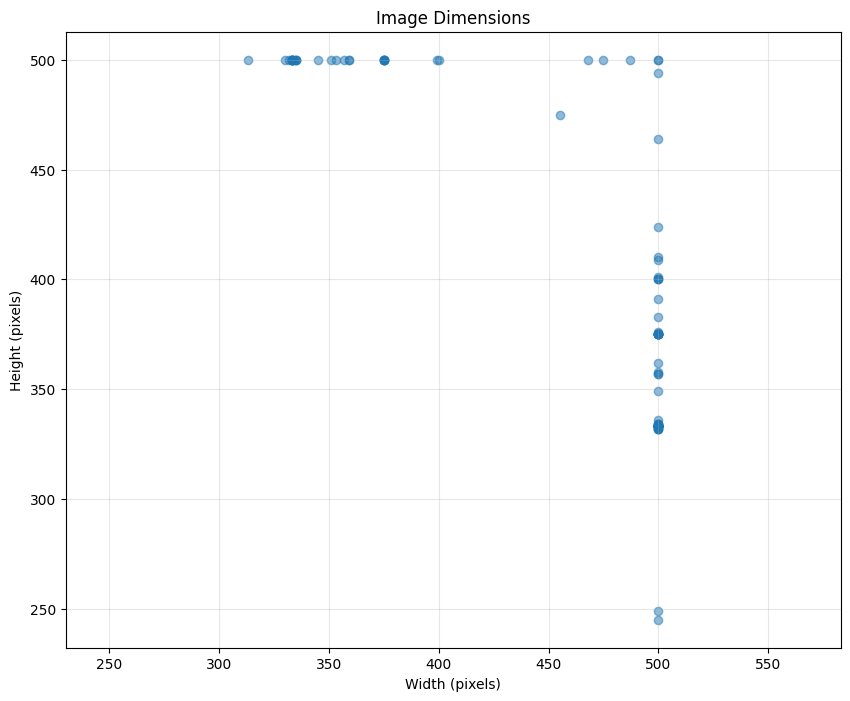

In [ ]:
# Plot image dimensions
plt.figure(figsize=(10, 8))
plt.scatter(image_dimensions['width'], image_dimensions['height'], alpha=0.5)
plt.title('Image Dimensions')
plt.xlabel('Width (pixels)')
plt.ylabel('Height (pixels)')
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.show()

## Summary

In this notebook, we have explored the Flickr8k dataset for image captioning. We have:

1. Downloaded and prepared the dataset
2. Explored the images and captions
3. Analyzed the distribution of caption lengths
4. Examined the vocabulary and its coverage
5. Built and saved the vocabulary
6. Explored the data splits
7. Checked image dimensions

This exploration gives us a good understanding of the dataset and helps us make informed decisions when designing our image captioning model.